## 0. import modules

In [1]:
import pandas as pd
import common
import yaml
from files import p2vmap
import gensim
import numpy as np
import sklearn.manifold

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Read in files

In [2]:
baskets = pd.read_parquet('files/market-baskets.parquet')
del baskets["customer"]

In [3]:
#baskets.groupby('basket').product.count().hist()

## Descriptive anaylsis

In [4]:
df = pd.DataFrame({
    'basket':np.repeat(baskets['basket'].unique(), baskets['product'].nunique()),
    'product':list(range(300))*baskets['basket'].nunique(),
    'present':0
        })

In [5]:
with open('files/config-w2v.yaml') as file:
    config_w2v = yaml.full_load(file)
    
with open('files/config-p2vmap.yaml') as file:
    config_p2vmap = yaml.full_load(file)

## 2. Apply word to vector model

In [6]:
basket_list = p2vmap.baskets_df_to_list(x=baskets.head(1_000_000), **config_w2v["baskets_df_to_list"])
w2v = gensim.models.Word2Vec(basket_list, **config_w2v["Word2Vec"])
product_embedding = p2vmap.gensim_to_pandas(w2v)[0]

## 3. Create plot from embeddings

In [7]:
product = pd.DataFrame(
    {
        "product": list(range(300)),
        "category": np.repeat(range(20), 15),
    }
)

In [8]:
x = product_embedding.values
x /= np.linalg.norm(x, axis=1)[:, np.newaxis]

res_tsne = sklearn.manifold.TSNE(**config_w2v["TSNE"]).fit_transform(x)

tsne_map_xy = pd.DataFrame(
    res_tsne,
    index=product[["category", "product"]].set_index(["category", "product"]).index,
    columns=["x", "y"],
).reset_index()

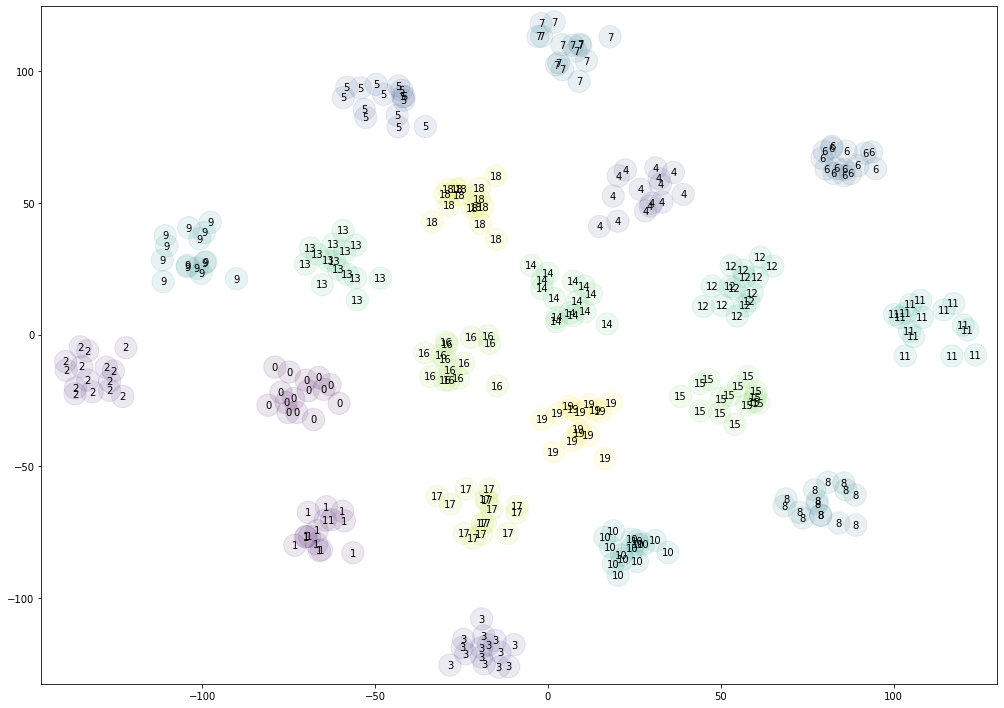

In [12]:
p2vmap.plot_tsne(tsne_map_xy, plotlabels=True, scatter=10)